In [1]:
pip install moviepy opencv-python numpy tensorflow scikit-learn flask

^C
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import cv2
import os
from moviepy.editor import VideoFileClip
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json


In [5]:
def create_directories():
    directories = [
        '../models',
        '../models/checkpoints',
        '../logs',
        '../logs/training_history',
        '../evaluation'
    ]
    for dir in directories:
        os.makedirs(dir, exist_ok=True)


In [6]:
create_directories()

In [10]:
class VideoFrameExtractor:
    def __init__(self, sample_rate=1):
        self.sample_rate = sample_rate
        self.face_cascade = cv2.CascadeClassifier(
            cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
        )
        
    def extract_faces_from_frame(self, frame):
        """Extract faces from a single frame using OpenCV"""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(30, 30)
        )
        
        if len(faces) == 0:
            return None
            
        processed_faces = []
        for (x, y, w, h) in faces:
            face = frame[y:y+h, x:x+w]
            face = cv2.resize(face, (128, 128))
            processed_faces.append(face)
            
        return processed_faces

    def process_video(self, video_path):
        """Process video and extract faces"""
        frames = []
        try:
            clip = VideoFileClip(video_path)
            for i, frame in enumerate(clip.iter_frames()):
                if i % self.sample_rate == 0:
                    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                    faces = self.extract_faces_from_frame(frame)
                    if faces:
                        frames.extend(faces)
            clip.close()
        except Exception as e:
            print(f"Error processing video {video_path}: {e}")
        return np.array(frames) if frames else None


In [13]:
def prepare_dataset(real_dir='../dataset/real_videos', fake_dir='../dataset/fake_videos'):
    """Prepare dataset from videos"""
    extractor = VideoFrameExtractor(sample_rate=30)  # 1 frame per second for 30fps videos
    X = []
    y = []
    
    # Process real videos
    print("Processing real videos...")
    for video in os.listdir(real_dir):
        print(f"Processing {video}")
        video_path = os.path.join(real_dir, video)
        frames = extractor.process_video(video_path)
        if frames is not None:
            X.extend(frames)
            y.extend([0] * len(frames))  # 0 for real
    
    # Process fake videos
    print("\nProcessing fake videos...")
    for video in os.listdir(fake_dir):
        print(f"Processing {video}")
        video_path = os.path.join(fake_dir, video)
        frames = extractor.process_video(video_path)
        if frames is not None:
            X.extend(frames)
            y.extend([1] * len(frames))  # 1 for fake
    
    return np.array(X), np.array(y)

In [19]:
# Load and prepare dataset
print("Starting dataset preparation...")
X, y = prepare_dataset()
X = X / 255.0  # Normalize pixel values

Starting dataset preparation...
Processing real videos...
Processing id0_0000.mp4
Processing id0_0001.mp4
Processing id0_0002.mp4
Processing id0_0003.mp4
Processing id0_0004.mp4
Processing id0_0005.mp4
Processing id0_0006.mp4
Processing id0_0007.mp4
Processing id0_0008.mp4
Processing id0_0009.mp4
Processing id10_0000.mp4
Processing id10_0001.mp4
Processing id10_0002.mp4
Processing id10_0003.mp4
Processing id10_0004.mp4
Processing id10_0005.mp4
Processing id10_0006.mp4
Processing id10_0007.mp4
Processing id10_0008.mp4
Processing id10_0009.mp4
Processing id11_0000.mp4
Processing id11_0001.mp4
Processing id11_0002.mp4
Processing id11_0003.mp4
Processing id11_0004.mp4
Processing id11_0005.mp4
Processing id11_0006.mp4
Processing id11_0007.mp4
Processing id11_0008.mp4
Processing id11_0009.mp4
Processing id11_0010.mp4
Processing id12_0000.mp4
Processing id12_0001.mp4
Processing id12_0002.mp4
Processing id12_0003.mp4
Processing id12_0004.mp4
Processing id12_0005.mp4
Processing id12_0006.mp4
Pr

MemoryError: Unable to allocate 38.7 GiB for an array with shape (105616, 128, 128, 3) and data type float64

In [20]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 84492
Testing samples: 21124


In [21]:
def create_model():
    """Create the model architecture"""
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(128, 128, 3)
    )
    
    # Freeze the base model
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model


In [22]:
# Create and compile model
model = create_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [27]:
# Setup callbacks
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f'../models/checkpoints/model_{timestamp}_{{epoch:02d}}-{{val_accuracy:.4f}}.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [28]:
# Train model
print("\nStarting model training...")
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[model_checkpoint, early_stopping]
)



Starting model training...
Epoch 1/10
2641/2641 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.9042 - auc: 0.6240 - loss: 0.3143
Epoch 1: val_accuracy improved from -inf to 0.91166, saving model to ../models/checkpoints/model_20241106_195343_01-0.9117.keras
2641/2641 ━━━━━━━━━━━━━━━━━━━━ 2107s 781ms/step - accuracy: 0.9042 - auc: 0.6240 - loss: 0.3143 - val_accuracy: 0.9117 - val_auc: 0.7822 - val_loss: 0.2609
Epoch 2/10
2641/2641 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.9115 - auc: 0.7507 - loss: 0.2703
Epoch 2: val_accuracy did not improve from 0.91166
2641/2641 ━━━━━━━━━━━━━━━━━━━━ 1709s 647ms/step - accuracy: 0.9115 - auc: 0.7507 - loss: 0.2703 - val_accuracy: 0.9093 - val_auc: 0.7942 - val_loss: 0.2646
Epoch 3/10
2641/2641 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.9149 - auc: 0.7802 - loss: 0.2563
Epoch 3: val_accuracy improved from 0.91166 to 0.91588, saving model to ../models/checkpoints/model_20241106_195343_03-0.9159.keras
2641/2641 ━━━━━━━━━━━━━━━━━━━━ 1554s

In [29]:
# Save the final model
final_model_path = f'../models/deepfake_detector_{timestamp}.h5'
model.save(final_model_path)
print(f"\nFinal model saved to: {final_model_path}")


Final model saved to: ../models/deepfake_detector_20241106_195343.h5


In [32]:
import json

# Save training history
history_dict = history.history
history_path = f'../logs/training_history/history_{timestamp}.json'
with open(history_path, 'w') as f:
    json.dump(history_dict, f)


In [33]:
# Plot and save training curves
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

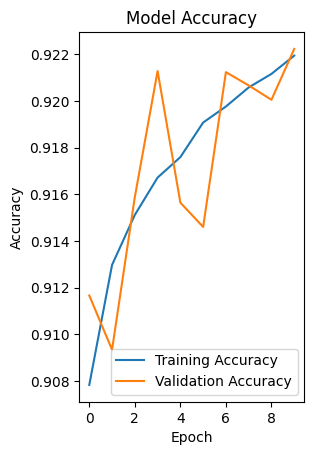

In [34]:
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [35]:
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig(f'../evaluation/training_curves_{timestamp}.png')
plt.close()

In [36]:
# Evaluate model on test set
print("\nEvaluating model on test set...")
test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test, verbose=1)


Evaluating model on test set...
661/661 ━━━━━━━━━━━━━━━━━━━━ 321s 486ms/step - accuracy: 0.9185 - auc: 0.8360 - loss: 0.2335


In [37]:
# Save evaluation metrics
evaluation_results = {
    'test_loss': test_loss,
    'test_accuracy': test_accuracy,
    'test_auc': test_auc,
    'timestamp': timestamp,
    'model_path': final_model_path,
    'training_params': {
        'batch_size': 32,
        'initial_epochs': 10,
        'learning_rate': 0.001
    }
}

with open(f'../evaluation/evaluation_results_{timestamp}.json', 'w') as f:
    json.dump(evaluation_results, f, indent=4)

print("\nTraining completed!")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print("\nFiles saved:")
print(f"- Model: {final_model_path}")
print(f"- Training history: {history_path}")
print(f"- Training curves: evaluation/training_curves_{timestamp}.png")
print(f"- Evaluation results: evaluation/evaluation_results_{timestamp}.json")


Training completed!
Test Accuracy: 0.9207
Test AUC: 0.8412

Files saved:
- Model: ../models/deepfake_detector_20241106_195343.h5
- Training history: ../logs/training_history/history_20241106_195343.json
- Training curves: evaluation/training_curves_20241106_195343.png
- Evaluation results: evaluation/evaluation_results_20241106_195343.json
